In [1]:
from biopandas.pdb import PandasPdb
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

import biopandas as bpd
import Levenshtein
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost

In [2]:
# Initialization
pandarallel.initialize(use_memory_fs=False)
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
#https://www.kaggle.com/datasets/alejopaullier/aminoacids-physical-and-chemical-properties
aminoacids = pd.read_csv('./aminoacids.csv')
aminoacids.rename(
    columns={
        col: col.lower().strip().replace(' ', '_') 
        for col in aminoacids.columns
    }, inplace=True
)

In [4]:
protein_lists_pbd = pd.read_csv('./similar_protein_sequences.csv', index_col="seq_id")

In [5]:
df_train = pd.read_csv("./starting_folder/raw_data/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("./starting_folder/raw_data/train_updates_20220929.csv", index_col="seq_id")
bio_df = PandasPdb().read_pdb('./starting_folder/raw_data/wildtype_structure_prediction_af2.pdb')
all_features_nan = df_train_updates.isnull().all("columns")
drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]
df_train = df_train[df_train.protein_sequence.notna()]
df_train = df_train[df_train.pH.notna()]

In [6]:
df_train['protein_len'] = df_train.protein_sequence.str.len()

In [7]:
def similarity_levenshtein(protein1, protein2):
    distance = Levenshtein.distance(protein1, protein2)
    return distance

def change_positions(protein1, protein2):
    edit_operations = Levenshtein.editops(protein1, protein2)
    result_positions = [element[1] for element in edit_operations]
    return result_positions

def get_protein_similarity_groups(protein_sequence):
    lenght_protein = len(protein_sequence)
    upper_val = lenght_protein + 50
    lower_val = lenght_protein - 50

    filtered_df_train = df_train[
        df_train.protein_len.between(
            lower_val, upper_val
        )
    ]
    protein_seq_similarity_levenshtein = filtered_df_train.protein_sequence.apply(
        lambda protein_sequence2: similarity_levenshtein(
            protein_sequence, protein_sequence2
        )
    )
    levenshtein_list = protein_seq_similarity_levenshtein[
        protein_seq_similarity_levenshtein < 10 # Why 10? 
    ].index.to_list()    
    return levenshtein_list

In [8]:
group_lists = df_train.protein_sequence.parallel_apply(get_protein_similarity_groups)

In [9]:
group_lists_df = pd.DataFrame(group_lists).rename(columns={'protein_sequence': 'group_list'})
group_lists_df['group_list_len'] = group_lists_df.group_list.apply(len)
group_lists_df['group_list_str'] = group_lists_df.group_list.apply(str)

In [10]:
grouped_4_proteins = group_lists_df[group_lists_df.group_list_len > 4]
relevant_groups = {
    gr:f'{i}_group'
    for i, gr in 
    enumerate(
        grouped_4_proteins.group_list_str.unique()
    )
}
grouped_4_proteins['group_str'] = grouped_4_proteins.group_list_str.map(relevant_groups)
df_train.loc[grouped_4_proteins.index, 'group'] = grouped_4_proteins.group_str
reduced_df_train = df_train[df_train.group.notna()]
reduced_df_train['pdb_list'] = protein_lists_pbd.loc[reduced_df_train.index].protein_sequence

In [11]:
def get_paired_mutations(tmp):
    x2 = tmp.protein_sequence.to_list()
    zero_matrix = np.zeros((len(tmp), len(tmp)))
    single_distances_pairs = []
    new_rows = []
    for i, word in enumerate(x2):
        for j, word2 in enumerate(x2):
            distance = similarity_levenshtein(word, word2)
            zero_matrix[i,j] = distance
            if 0 < distance <= 1:
                if i<j:
                    continue
                else:
                    single_distances_pairs.append((i,j))
                    row1 = tmp.iloc[i]
                    row2 = tmp.iloc[j]
                    dd = {}
                    indexes_of_change = change_positions(word, word2)
                    wildtype = word[indexes_of_change[0]]
                    mutation = word2[indexes_of_change[0]]
                    dd['seq1'] = row1.protein_sequence
                    dd['tm1'] = row1.tm
                    dd['ds1'] = row1.data_source
                    dd['pH1'] = row1.pH
                    dd['len1'] = row1.protein_len
                    dd['list1'] = row1.pdb_list
                    dd['seq2'] = row2.protein_sequence
                    dd['tm2'] = row2.tm
                    dd['ds2'] = row2.data_source
                    dd['pH2'] = row2.pH
                    dd['len2'] = row2.protein_len
                    dd['list2'] = row2.pdb_list
                    dd['mutation_type'] = distance
                    dd['mutation'] = mutation
                    dd['wildtype'] = wildtype
                    dd['edit_operations'] = indexes_of_change
                    new_rows.append(dd)
    new_df = pd.DataFrame(new_rows)
    return new_df

In [12]:
paired_df = reduced_df_train.groupby('group').apply(get_paired_mutations)
#paired_df_changes = paired_df[~(paired_df.mutation_type==0 & (paired_df.pH1==paired_df.pH2))]

In [13]:
temporal_data = paired_df.copy().reset_index()
temporal_data = temporal_data.drop(
    ['level_1','seq1','ds1','seq2', 'ds2', 'len2'],
    axis=1
)

def get_initial_protein_from_list(protein_list_str):
    initial_protein = protein_list_str.replace(
        "'", '').split(',')[0][1:]
    return initial_protein

temporal_data['mutation_position'] =  temporal_data['edit_operations'].apply(lambda x: x[0])
    
temporal_data['relative_mutation_position'] = temporal_data['mutation_position']/temporal_data['len1']

temporal_data['representative_protein1'] = temporal_data.list1.apply(
    get_initial_protein_from_list
)

temporal_data['representative_protein2'] = temporal_data.list2.apply(
    get_initial_protein_from_list
)

temporal_data['keep_representative_protein'] = (
    temporal_data['representative_protein1'] == temporal_data['representative_protein2']
).astype('int')

temporal_data['d_pH'] = temporal_data['pH2'] - temporal_data['pH1']

In [14]:
def aminoacid_data(row):
    letter_wildtype = row.wildtype[0]
    letter_mutation = row.mutation[0]
    wild_amino = aminoacids[aminoacids.letter == letter_wildtype]
    muta_amino = aminoacids[aminoacids.letter == letter_mutation]
    cols = [
        'molecular_weight',
        'residue_weight',
        'pka1',
        'pkb2',
        'pkx3',
        'pl4',
        'h',
        'vsc',
        'p1',
        'p2',
        'sasa',
        'ncisc',
        'carbon',
        'hydrogen',
        'nitrogen',
        'oxygen',
        'sulfur'
    ]
    difference = (
        muta_amino[cols].reset_index(drop=True).T - 
        wild_amino[cols].reset_index(drop=True).T
    )
    result = dict(difference[0])
    return result

In [15]:
temporal_data_aminoacid_info = pd.json_normalize(
    temporal_data.parallel_apply(
        aminoacid_data, axis=1
    )
)

In [16]:
temporal_data_aminoacid_info

,molecular_weight,residue_weight,pka1,pkb2,pkx3,pl4,h,vsc,p1,p2,sasa,ncisc,carbon,hydrogen,nitrogen,oxygen,sulfur
0,-42.08,-42.08,-0.02,0.09,NaN,0.02,-0.44,-66.0,3.2,-0.140,-0.750,-0.044485,-3.0,-6.0,0.0,0.0,0.0
1,-30.02,-30.03,0.25,0.59,NaN,0.40,0.67,-23.8,-0.5,-0.062,-0.344,0.003835,-1.0,-2.0,0.0,-1.0,0.0
2,-57.05,-57.05,0.17,0.56,NaN,0.35,1.47,-53.2,-2.4,-0.134,-0.751,-0.042024,-2.0,-3.0,-1.0,-1.0,0.0
3,14.03,14.03,0.00,0.09,NaN,0.03,0.14,27.5,-0.9,0.046,0.300,-0.171865,1.0,2.0,0.0,0.0,0.0
4,14.03,14.03,0.00,0.09,NaN,0.03,0.14,27.5,-0.9,0.046,0.300,-0.171865,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11665,-42.08,-42.08,-0.02,0.09,NaN,0.02,-0.44,-66.0,3.2,-0.140,-0.750,-0.044485,-3.0,-6.0,0.0,0.0,0.0
11666,27.03,27.02,0.08,0.03,NaN,0.05,-0.80,29.4,1.9,0.072,0.407,0.045859,1.0,1.0,1.0,0.0,0.0
11667,-30.02,-30.03,0.25,0.59,NaN,0.40,0.67,-23.8,-0.5,-0.062,-0.344,0.003835,-1.0,-2.0,0.0,-1.0,0.0
11668,-57.09,-57.10,0.16,0.74,NaN,-3.74,2.12,-72.5,-3.2,-0.173,-1.077,-0.010521,-3.0,-7.0,-1.0,0.0,0.0


In [17]:

def protein_related_data(protein_pdb_name):
    protein_pbd_info = pd.read_csv(
        f'./protein_data/{protein_pdb_name}.csv',
        compression='gzip', 
        index_col=0
    )

    protein_pbd_info = protein_pbd_info[
        protein_pbd_info.record_name=='ATOM'
    ]

    x_range = protein_pbd_info.x_coord.max() - protein_pbd_info.x_coord.min()
    y_range = protein_pbd_info.y_coord.max() - protein_pbd_info.y_coord.min()
    z_range = protein_pbd_info.z_coord.max() - protein_pbd_info.z_coord.min()

    vol = x_range * y_range * z_range
    density = protein_pbd_info.atom_number.max() / vol
    b_factor_mean = protein_pbd_info.b_factor.mean()
    b_factor_std = protein_pbd_info.b_factor.std()
    b_factor_max = protein_pbd_info.b_factor.max()
    b_factor_min = protein_pbd_info.b_factor.min()

    results = {
        'x_range': x_range,
        'y_range': y_range,
        'z_range': z_range,
        'vol': vol,
        'density': density,
        'b_factor_mean': b_factor_mean,
        'b_fractor_std': b_factor_std,
        'b_factor_max': b_factor_max,
        'b_factor_min': b_factor_min,
    }
    return results

In [18]:
temporal_data_protein_info = pd.json_normalize(
    temporal_data.representative_protein1.parallel_apply(
        protein_related_data
    )
)

In [19]:
temporal_data['d_tm'] = temporal_data['tm2'] - temporal_data['tm1'] 

In [20]:
drop_cols = [
    'list1', 
    'len1',
    'tm2',
    'list2',
    'mutation', 
    'wildtype', 
    'edit_operations',
    'mutation_position',
    'representative_protein1',
    'representative_protein2',
]


In [21]:
final_train_data = pd.concat([
    temporal_data.drop(drop_cols, axis=1),
    temporal_data_protein_info, 
    temporal_data_aminoacid_info], axis=1)

In [22]:
unique_groups = final_train_data.group.unique()
test_groups = np.random.choice(
    unique_groups, int(len(unique_groups)*0.3)
)
remaining_groups = list(set(unique_groups) - set(test_groups))
dev_groups = np.random.choice(
    remaining_groups, int(len(unique_groups)*0.2)
)

train_groups = list(set(remaining_groups) - set(dev_groups))

In [23]:
test_data = final_train_data[final_train_data.group.isin(test_groups)]
dev_data = final_train_data[final_train_data.group.isin(dev_groups)]
train_data = final_train_data[final_train_data.group.isin(train_groups)]

In [24]:
non_train_data = ['group', 'd_tm']
X_train, y_train = train_data.drop(non_train_data, axis=1), train_data.d_tm
X_test, y_test = test_data.drop(non_train_data, axis=1), test_data.d_tm
X_dev, y_dev = test_data.drop(non_train_data, axis=1), test_data.d_tm


In [25]:
model = xgboost.XGBRegressor(
    n_estimators=100000,
    max_depth=4,
    learning_rate=0.001,
    subsample=0.6,
    colsample_bytree=0.2,
    
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_dev, y_dev)],
    early_stopping_rounds=1000,
)

[0]	validation_0-rmse:11.89109	validation_1-rmse:9.27786
[1]	validation_0-rmse:11.88973	validation_1-rmse:9.27806
[2]	validation_0-rmse:11.88826	validation_1-rmse:9.27756
[3]	validation_0-rmse:11.88686	validation_1-rmse:9.27759
[4]	validation_0-rmse:11.88514	validation_1-rmse:9.27761
[5]	validation_0-rmse:11.88431	validation_1-rmse:9.27750
[6]	validation_0-rmse:11.88281	validation_1-rmse:9.27716
[7]	validation_0-rmse:11.88149	validation_1-rmse:9.27715
[8]	validation_0-rmse:11.87936	validation_1-rmse:9.27719
[9]	validation_0-rmse:11.87537	validation_1-rmse:9.27433
[10]	validation_0-rmse:11.87425	validation_1-rmse:9.27450
[11]	validation_0-rmse:11.87278	validation_1-rmse:9.27399
[12]	validation_0-rmse:11.87199	validation_1-rmse:9.27432
[13]	validation_0-rmse:11.87006	validation_1-rmse:9.27439
[14]	validation_0-rmse:11.86825	validation_1-rmse:9.27406
[15]	validation_0-rmse:11.86719	validation_1-rmse:9.27407
[16]	validation_0-rmse:11.86522	validation_1-rmse:9.27411
[17]	validation_0-rmse:1

[141]	validation_0-rmse:11.60893	validation_1-rmse:9.20721
[142]	validation_0-rmse:11.60718	validation_1-rmse:9.20791
[143]	validation_0-rmse:11.60540	validation_1-rmse:9.20791
[144]	validation_0-rmse:11.60356	validation_1-rmse:9.20846
[145]	validation_0-rmse:11.60187	validation_1-rmse:9.20846
[146]	validation_0-rmse:11.60045	validation_1-rmse:9.20806
[147]	validation_0-rmse:11.59863	validation_1-rmse:9.20804
[148]	validation_0-rmse:11.59687	validation_1-rmse:9.20764
[149]	validation_0-rmse:11.59545	validation_1-rmse:9.20742
[150]	validation_0-rmse:11.59365	validation_1-rmse:9.20747
[151]	validation_0-rmse:11.59237	validation_1-rmse:9.20702
[152]	validation_0-rmse:11.59143	validation_1-rmse:9.20689
[153]	validation_0-rmse:11.58697	validation_1-rmse:9.20385
[154]	validation_0-rmse:11.58524	validation_1-rmse:9.20290
[155]	validation_0-rmse:11.58408	validation_1-rmse:9.20253
[156]	validation_0-rmse:11.58246	validation_1-rmse:9.20233
[157]	validation_0-rmse:11.58121	validation_1-rmse:9.202

[280]	validation_0-rmse:11.33828	validation_1-rmse:9.12984
[281]	validation_0-rmse:11.33487	validation_1-rmse:9.12758
[282]	validation_0-rmse:11.33308	validation_1-rmse:9.12730
[283]	validation_0-rmse:11.33116	validation_1-rmse:9.12735
[284]	validation_0-rmse:11.32980	validation_1-rmse:9.12701
[285]	validation_0-rmse:11.32883	validation_1-rmse:9.12686
[286]	validation_0-rmse:11.32741	validation_1-rmse:9.12663
[287]	validation_0-rmse:11.32646	validation_1-rmse:9.12645
[288]	validation_0-rmse:11.32509	validation_1-rmse:9.12626
[289]	validation_0-rmse:11.32359	validation_1-rmse:9.12635
[290]	validation_0-rmse:11.32151	validation_1-rmse:9.12631
[291]	validation_0-rmse:11.31978	validation_1-rmse:9.12693
[292]	validation_0-rmse:11.31884	validation_1-rmse:9.12672
[293]	validation_0-rmse:11.31769	validation_1-rmse:9.12630
[294]	validation_0-rmse:11.31365	validation_1-rmse:9.12437
[295]	validation_0-rmse:11.31283	validation_1-rmse:9.12435
[296]	validation_0-rmse:11.30888	validation_1-rmse:9.122

[419]	validation_0-rmse:11.09945	validation_1-rmse:9.07603
[420]	validation_0-rmse:11.09791	validation_1-rmse:9.07616
[421]	validation_0-rmse:11.09624	validation_1-rmse:9.07609
[422]	validation_0-rmse:11.09537	validation_1-rmse:9.07602
[423]	validation_0-rmse:11.09395	validation_1-rmse:9.07566
[424]	validation_0-rmse:11.09250	validation_1-rmse:9.07587
[425]	validation_0-rmse:11.09115	validation_1-rmse:9.07570
[426]	validation_0-rmse:11.08738	validation_1-rmse:9.07313
[427]	validation_0-rmse:11.08625	validation_1-rmse:9.07342
[428]	validation_0-rmse:11.08525	validation_1-rmse:9.07336
[429]	validation_0-rmse:11.08183	validation_1-rmse:9.07093
[430]	validation_0-rmse:11.08030	validation_1-rmse:9.07072
[431]	validation_0-rmse:11.07913	validation_1-rmse:9.07049
[432]	validation_0-rmse:11.07790	validation_1-rmse:9.07062
[433]	validation_0-rmse:11.07630	validation_1-rmse:9.07050
[434]	validation_0-rmse:11.07523	validation_1-rmse:9.07086
[435]	validation_0-rmse:11.07382	validation_1-rmse:9.070

[558]	validation_0-rmse:10.88639	validation_1-rmse:9.03353
[559]	validation_0-rmse:10.88521	validation_1-rmse:9.03320
[560]	validation_0-rmse:10.88392	validation_1-rmse:9.03346
[561]	validation_0-rmse:10.88268	validation_1-rmse:9.03374
[562]	validation_0-rmse:10.87901	validation_1-rmse:9.03162
[563]	validation_0-rmse:10.87791	validation_1-rmse:9.03189
[564]	validation_0-rmse:10.87659	validation_1-rmse:9.03151
[565]	validation_0-rmse:10.87535	validation_1-rmse:9.03204
[566]	validation_0-rmse:10.87471	validation_1-rmse:9.03204
[567]	validation_0-rmse:10.87353	validation_1-rmse:9.03218
[568]	validation_0-rmse:10.87299	validation_1-rmse:9.03219
[569]	validation_0-rmse:10.87173	validation_1-rmse:9.03188
[570]	validation_0-rmse:10.87094	validation_1-rmse:9.03181
[571]	validation_0-rmse:10.87012	validation_1-rmse:9.03237
[572]	validation_0-rmse:10.86903	validation_1-rmse:9.03246
[573]	validation_0-rmse:10.86518	validation_1-rmse:9.03117
[574]	validation_0-rmse:10.86398	validation_1-rmse:9.031

[697]	validation_0-rmse:10.70549	validation_1-rmse:9.01396
[698]	validation_0-rmse:10.70418	validation_1-rmse:9.01475
[699]	validation_0-rmse:10.70348	validation_1-rmse:9.01461
[700]	validation_0-rmse:10.70253	validation_1-rmse:9.01443
[701]	validation_0-rmse:10.70164	validation_1-rmse:9.01491
[702]	validation_0-rmse:10.70087	validation_1-rmse:9.01492
[703]	validation_0-rmse:10.69723	validation_1-rmse:9.01401
[704]	validation_0-rmse:10.69638	validation_1-rmse:9.01402
[705]	validation_0-rmse:10.69545	validation_1-rmse:9.01372
[706]	validation_0-rmse:10.69470	validation_1-rmse:9.01382
[707]	validation_0-rmse:10.69127	validation_1-rmse:9.01197
[708]	validation_0-rmse:10.69037	validation_1-rmse:9.01176
[709]	validation_0-rmse:10.68942	validation_1-rmse:9.01160
[710]	validation_0-rmse:10.68836	validation_1-rmse:9.01157
[711]	validation_0-rmse:10.68746	validation_1-rmse:9.01163
[712]	validation_0-rmse:10.68646	validation_1-rmse:9.01213
[713]	validation_0-rmse:10.68520	validation_1-rmse:9.012

[836]	validation_0-rmse:10.52359	validation_1-rmse:8.97988
[837]	validation_0-rmse:10.52278	validation_1-rmse:8.97968
[838]	validation_0-rmse:10.52197	validation_1-rmse:8.97961
[839]	validation_0-rmse:10.52062	validation_1-rmse:8.97977
[840]	validation_0-rmse:10.51980	validation_1-rmse:8.97975
[841]	validation_0-rmse:10.51922	validation_1-rmse:8.98003
[842]	validation_0-rmse:10.51794	validation_1-rmse:8.98024
[843]	validation_0-rmse:10.51699	validation_1-rmse:8.98050
[844]	validation_0-rmse:10.51576	validation_1-rmse:8.98100
[845]	validation_0-rmse:10.51481	validation_1-rmse:8.98105
[846]	validation_0-rmse:10.51188	validation_1-rmse:8.97992
[847]	validation_0-rmse:10.51052	validation_1-rmse:8.98060
[848]	validation_0-rmse:10.50971	validation_1-rmse:8.98080
[849]	validation_0-rmse:10.50896	validation_1-rmse:8.98077
[850]	validation_0-rmse:10.50814	validation_1-rmse:8.98055
[851]	validation_0-rmse:10.50752	validation_1-rmse:8.98037
[852]	validation_0-rmse:10.50644	validation_1-rmse:8.980

[975]	validation_0-rmse:10.35876	validation_1-rmse:8.95051
[976]	validation_0-rmse:10.35822	validation_1-rmse:8.95090
[977]	validation_0-rmse:10.35785	validation_1-rmse:8.95100
[978]	validation_0-rmse:10.35755	validation_1-rmse:8.95095
[979]	validation_0-rmse:10.35394	validation_1-rmse:8.94902
[980]	validation_0-rmse:10.35335	validation_1-rmse:8.94911
[981]	validation_0-rmse:10.35040	validation_1-rmse:8.94717
[982]	validation_0-rmse:10.34924	validation_1-rmse:8.94698
[983]	validation_0-rmse:10.34866	validation_1-rmse:8.94699
[984]	validation_0-rmse:10.34793	validation_1-rmse:8.94723
[985]	validation_0-rmse:10.34719	validation_1-rmse:8.94714
[986]	validation_0-rmse:10.34430	validation_1-rmse:8.94550
[987]	validation_0-rmse:10.34345	validation_1-rmse:8.94550
[988]	validation_0-rmse:10.34215	validation_1-rmse:8.94558
[989]	validation_0-rmse:10.34091	validation_1-rmse:8.94544
[990]	validation_0-rmse:10.34043	validation_1-rmse:8.94544
[991]	validation_0-rmse:10.33686	validation_1-rmse:8.943

[1112]	validation_0-rmse:10.17640	validation_1-rmse:8.90393
[1113]	validation_0-rmse:10.17547	validation_1-rmse:8.90424
[1114]	validation_0-rmse:10.17493	validation_1-rmse:8.90428
[1115]	validation_0-rmse:10.17422	validation_1-rmse:8.90398
[1116]	validation_0-rmse:10.17362	validation_1-rmse:8.90400
[1117]	validation_0-rmse:10.17306	validation_1-rmse:8.90411
[1118]	validation_0-rmse:10.16994	validation_1-rmse:8.90290
[1119]	validation_0-rmse:10.16914	validation_1-rmse:8.90298
[1120]	validation_0-rmse:10.16813	validation_1-rmse:8.90282
[1121]	validation_0-rmse:10.16744	validation_1-rmse:8.90257
[1122]	validation_0-rmse:10.16676	validation_1-rmse:8.90265
[1123]	validation_0-rmse:10.16366	validation_1-rmse:8.90198
[1124]	validation_0-rmse:10.16322	validation_1-rmse:8.90194
[1125]	validation_0-rmse:10.16245	validation_1-rmse:8.90196
[1126]	validation_0-rmse:10.16148	validation_1-rmse:8.90243
[1127]	validation_0-rmse:10.16056	validation_1-rmse:8.90254
[1128]	validation_0-rmse:10.15961	valida

[1249]	validation_0-rmse:10.03187	validation_1-rmse:8.88207
[1250]	validation_0-rmse:10.03144	validation_1-rmse:8.88205
[1251]	validation_0-rmse:10.03087	validation_1-rmse:8.88228
[1252]	validation_0-rmse:10.02975	validation_1-rmse:8.88249
[1253]	validation_0-rmse:10.02690	validation_1-rmse:8.88042
[1254]	validation_0-rmse:10.02611	validation_1-rmse:8.88039
[1255]	validation_0-rmse:10.02539	validation_1-rmse:8.88043
[1256]	validation_0-rmse:10.02467	validation_1-rmse:8.88045
[1257]	validation_0-rmse:10.02429	validation_1-rmse:8.88048
[1258]	validation_0-rmse:10.02156	validation_1-rmse:8.87911
[1259]	validation_0-rmse:10.01866	validation_1-rmse:8.87696
[1260]	validation_0-rmse:10.01815	validation_1-rmse:8.87682
[1261]	validation_0-rmse:10.01777	validation_1-rmse:8.87681
[1262]	validation_0-rmse:10.01658	validation_1-rmse:8.87691
[1263]	validation_0-rmse:10.01629	validation_1-rmse:8.87700
[1264]	validation_0-rmse:10.01579	validation_1-rmse:8.87695
[1265]	validation_0-rmse:10.01468	valida

[1388]	validation_0-rmse:9.87801	validation_1-rmse:8.84958
[1389]	validation_0-rmse:9.87536	validation_1-rmse:8.84804
[1390]	validation_0-rmse:9.87465	validation_1-rmse:8.84846
[1391]	validation_0-rmse:9.87167	validation_1-rmse:8.84730
[1392]	validation_0-rmse:9.86864	validation_1-rmse:8.84649
[1393]	validation_0-rmse:9.86828	validation_1-rmse:8.84667
[1394]	validation_0-rmse:9.86740	validation_1-rmse:8.84626
[1395]	validation_0-rmse:9.86636	validation_1-rmse:8.84608
[1396]	validation_0-rmse:9.86549	validation_1-rmse:8.84611
[1397]	validation_0-rmse:9.86485	validation_1-rmse:8.84597
[1398]	validation_0-rmse:9.86428	validation_1-rmse:8.84598
[1399]	validation_0-rmse:9.86352	validation_1-rmse:8.84613
[1400]	validation_0-rmse:9.86318	validation_1-rmse:8.84614
[1401]	validation_0-rmse:9.86196	validation_1-rmse:8.84631
[1402]	validation_0-rmse:9.86132	validation_1-rmse:8.84621
[1403]	validation_0-rmse:9.86018	validation_1-rmse:8.84619
[1404]	validation_0-rmse:9.85939	validation_1-rmse:8.846

[1526]	validation_0-rmse:9.74652	validation_1-rmse:8.83659
[1527]	validation_0-rmse:9.74574	validation_1-rmse:8.83737
[1528]	validation_0-rmse:9.74477	validation_1-rmse:8.83771
[1529]	validation_0-rmse:9.74418	validation_1-rmse:8.83751
[1530]	validation_0-rmse:9.74366	validation_1-rmse:8.83738
[1531]	validation_0-rmse:9.74332	validation_1-rmse:8.83730
[1532]	validation_0-rmse:9.74253	validation_1-rmse:8.83720
[1533]	validation_0-rmse:9.74008	validation_1-rmse:8.83663
[1534]	validation_0-rmse:9.73949	validation_1-rmse:8.83644
[1535]	validation_0-rmse:9.73874	validation_1-rmse:8.83665
[1536]	validation_0-rmse:9.73837	validation_1-rmse:8.83692
[1537]	validation_0-rmse:9.73764	validation_1-rmse:8.83707
[1538]	validation_0-rmse:9.73740	validation_1-rmse:8.83713
[1539]	validation_0-rmse:9.73436	validation_1-rmse:8.83567
[1540]	validation_0-rmse:9.73369	validation_1-rmse:8.83549
[1541]	validation_0-rmse:9.73334	validation_1-rmse:8.83549
[1542]	validation_0-rmse:9.73293	validation_1-rmse:8.835

[1665]	validation_0-rmse:9.62053	validation_1-rmse:8.81811
[1666]	validation_0-rmse:9.62002	validation_1-rmse:8.81833
[1667]	validation_0-rmse:9.61957	validation_1-rmse:8.81842
[1668]	validation_0-rmse:9.61881	validation_1-rmse:8.81850
[1669]	validation_0-rmse:9.61577	validation_1-rmse:8.81731
[1670]	validation_0-rmse:9.61304	validation_1-rmse:8.81607
[1671]	validation_0-rmse:9.60984	validation_1-rmse:8.81448
[1672]	validation_0-rmse:9.60709	validation_1-rmse:8.81362
[1673]	validation_0-rmse:9.60400	validation_1-rmse:8.81219
[1674]	validation_0-rmse:9.60361	validation_1-rmse:8.81282
[1675]	validation_0-rmse:9.60323	validation_1-rmse:8.81284
[1676]	validation_0-rmse:9.60293	validation_1-rmse:8.81287
[1677]	validation_0-rmse:9.60235	validation_1-rmse:8.81277
[1678]	validation_0-rmse:9.60213	validation_1-rmse:8.81274
[1679]	validation_0-rmse:9.60000	validation_1-rmse:8.81097
[1680]	validation_0-rmse:9.59960	validation_1-rmse:8.81109
[1681]	validation_0-rmse:9.59895	validation_1-rmse:8.811

[1804]	validation_0-rmse:9.49489	validation_1-rmse:8.79716
[1805]	validation_0-rmse:9.49417	validation_1-rmse:8.79705
[1806]	validation_0-rmse:9.49353	validation_1-rmse:8.79727
[1807]	validation_0-rmse:9.49244	validation_1-rmse:8.79720
[1808]	validation_0-rmse:9.49193	validation_1-rmse:8.79740
[1809]	validation_0-rmse:9.49119	validation_1-rmse:8.79775
[1810]	validation_0-rmse:9.49041	validation_1-rmse:8.79796
[1811]	validation_0-rmse:9.48775	validation_1-rmse:8.79655
[1812]	validation_0-rmse:9.48723	validation_1-rmse:8.79687
[1813]	validation_0-rmse:9.48712	validation_1-rmse:8.79684
[1814]	validation_0-rmse:9.48672	validation_1-rmse:8.79675
[1815]	validation_0-rmse:9.48608	validation_1-rmse:8.79772
[1816]	validation_0-rmse:9.48590	validation_1-rmse:8.79768
[1817]	validation_0-rmse:9.48576	validation_1-rmse:8.79785
[1818]	validation_0-rmse:9.48554	validation_1-rmse:8.79811
[1819]	validation_0-rmse:9.48531	validation_1-rmse:8.79813
[1820]	validation_0-rmse:9.48500	validation_1-rmse:8.798

[1943]	validation_0-rmse:9.38767	validation_1-rmse:8.78464
[1944]	validation_0-rmse:9.38735	validation_1-rmse:8.78557
[1945]	validation_0-rmse:9.38676	validation_1-rmse:8.78609
[1946]	validation_0-rmse:9.38659	validation_1-rmse:8.78614
[1947]	validation_0-rmse:9.38404	validation_1-rmse:8.78496
[1948]	validation_0-rmse:9.38347	validation_1-rmse:8.78494
[1949]	validation_0-rmse:9.38104	validation_1-rmse:8.78427
[1950]	validation_0-rmse:9.37895	validation_1-rmse:8.78319
[1951]	validation_0-rmse:9.37846	validation_1-rmse:8.78357
[1952]	validation_0-rmse:9.37825	validation_1-rmse:8.78361
[1953]	validation_0-rmse:9.37776	validation_1-rmse:8.78374
[1954]	validation_0-rmse:9.37713	validation_1-rmse:8.78395
[1955]	validation_0-rmse:9.37674	validation_1-rmse:8.78387
[1956]	validation_0-rmse:9.37599	validation_1-rmse:8.78468
[1957]	validation_0-rmse:9.37506	validation_1-rmse:8.78461
[1958]	validation_0-rmse:9.37446	validation_1-rmse:8.78452
[1959]	validation_0-rmse:9.37409	validation_1-rmse:8.784

[2082]	validation_0-rmse:9.27805	validation_1-rmse:8.77186
[2083]	validation_0-rmse:9.27769	validation_1-rmse:8.77184
[2084]	validation_0-rmse:9.27727	validation_1-rmse:8.77189
[2085]	validation_0-rmse:9.27672	validation_1-rmse:8.77198
[2086]	validation_0-rmse:9.27640	validation_1-rmse:8.77197
[2087]	validation_0-rmse:9.27615	validation_1-rmse:8.77202
[2088]	validation_0-rmse:9.27578	validation_1-rmse:8.77204
[2089]	validation_0-rmse:9.27514	validation_1-rmse:8.77257
[2090]	validation_0-rmse:9.27435	validation_1-rmse:8.77331
[2091]	validation_0-rmse:9.27189	validation_1-rmse:8.77154
[2092]	validation_0-rmse:9.27142	validation_1-rmse:8.77139
[2093]	validation_0-rmse:9.27122	validation_1-rmse:8.77144
[2094]	validation_0-rmse:9.27085	validation_1-rmse:8.77199
[2095]	validation_0-rmse:9.27055	validation_1-rmse:8.77193
[2096]	validation_0-rmse:9.27034	validation_1-rmse:8.77198
[2097]	validation_0-rmse:9.26986	validation_1-rmse:8.77196
[2098]	validation_0-rmse:9.26943	validation_1-rmse:8.772

[2221]	validation_0-rmse:9.16127	validation_1-rmse:8.74982
[2222]	validation_0-rmse:9.15931	validation_1-rmse:8.74875
[2223]	validation_0-rmse:9.15711	validation_1-rmse:8.74742
[2224]	validation_0-rmse:9.15626	validation_1-rmse:8.74746
[2225]	validation_0-rmse:9.15605	validation_1-rmse:8.74740
[2226]	validation_0-rmse:9.15544	validation_1-rmse:8.74745
[2227]	validation_0-rmse:9.15511	validation_1-rmse:8.74753
[2228]	validation_0-rmse:9.15463	validation_1-rmse:8.74763
[2229]	validation_0-rmse:9.15415	validation_1-rmse:8.74804
[2230]	validation_0-rmse:9.15404	validation_1-rmse:8.74801
[2231]	validation_0-rmse:9.15379	validation_1-rmse:8.74788
[2232]	validation_0-rmse:9.15135	validation_1-rmse:8.74684
[2233]	validation_0-rmse:9.15117	validation_1-rmse:8.74728
[2234]	validation_0-rmse:9.15075	validation_1-rmse:8.74715
[2235]	validation_0-rmse:9.15058	validation_1-rmse:8.74715
[2236]	validation_0-rmse:9.15045	validation_1-rmse:8.74702
[2237]	validation_0-rmse:9.14780	validation_1-rmse:8.745

[2360]	validation_0-rmse:9.06477	validation_1-rmse:8.74183
[2361]	validation_0-rmse:9.06269	validation_1-rmse:8.74104
[2362]	validation_0-rmse:9.06227	validation_1-rmse:8.74116
[2363]	validation_0-rmse:9.06195	validation_1-rmse:8.74125
[2364]	validation_0-rmse:9.06176	validation_1-rmse:8.74127
[2365]	validation_0-rmse:9.06138	validation_1-rmse:8.74101
[2366]	validation_0-rmse:9.06059	validation_1-rmse:8.74103
[2367]	validation_0-rmse:9.05812	validation_1-rmse:8.73982
[2368]	validation_0-rmse:9.05606	validation_1-rmse:8.73880
[2369]	validation_0-rmse:9.05579	validation_1-rmse:8.73887
[2370]	validation_0-rmse:9.05513	validation_1-rmse:8.73882
[2371]	validation_0-rmse:9.05486	validation_1-rmse:8.73872
[2372]	validation_0-rmse:9.05270	validation_1-rmse:8.73749
[2373]	validation_0-rmse:9.05248	validation_1-rmse:8.73750
[2374]	validation_0-rmse:9.05075	validation_1-rmse:8.73672
[2375]	validation_0-rmse:9.05040	validation_1-rmse:8.73698
[2376]	validation_0-rmse:9.05022	validation_1-rmse:8.737

[2499]	validation_0-rmse:8.96041	validation_1-rmse:8.72619
[2500]	validation_0-rmse:8.96005	validation_1-rmse:8.72617
[2501]	validation_0-rmse:8.95941	validation_1-rmse:8.72683
[2502]	validation_0-rmse:8.95915	validation_1-rmse:8.72682
[2503]	validation_0-rmse:8.95688	validation_1-rmse:8.72614
[2504]	validation_0-rmse:8.95463	validation_1-rmse:8.72633
[2505]	validation_0-rmse:8.95437	validation_1-rmse:8.72636
[2506]	validation_0-rmse:8.95396	validation_1-rmse:8.72632
[2507]	validation_0-rmse:8.95365	validation_1-rmse:8.72630
[2508]	validation_0-rmse:8.95349	validation_1-rmse:8.72627
[2509]	validation_0-rmse:8.95339	validation_1-rmse:8.72653
[2510]	validation_0-rmse:8.95304	validation_1-rmse:8.72644
[2511]	validation_0-rmse:8.95087	validation_1-rmse:8.72511
[2512]	validation_0-rmse:8.94864	validation_1-rmse:8.72377
[2513]	validation_0-rmse:8.94798	validation_1-rmse:8.72404
[2514]	validation_0-rmse:8.94767	validation_1-rmse:8.72406
[2515]	validation_0-rmse:8.94731	validation_1-rmse:8.724

[2638]	validation_0-rmse:8.87428	validation_1-rmse:8.71908
[2639]	validation_0-rmse:8.87378	validation_1-rmse:8.71962
[2640]	validation_0-rmse:8.87172	validation_1-rmse:8.71835
[2641]	validation_0-rmse:8.87121	validation_1-rmse:8.71857
[2642]	validation_0-rmse:8.87099	validation_1-rmse:8.71867
[2643]	validation_0-rmse:8.87068	validation_1-rmse:8.71846
[2644]	validation_0-rmse:8.87053	validation_1-rmse:8.71851
[2645]	validation_0-rmse:8.86828	validation_1-rmse:8.71794
[2646]	validation_0-rmse:8.86804	validation_1-rmse:8.71827
[2647]	validation_0-rmse:8.86707	validation_1-rmse:8.71918
[2648]	validation_0-rmse:8.86680	validation_1-rmse:8.71926
[2649]	validation_0-rmse:8.86665	validation_1-rmse:8.71932
[2650]	validation_0-rmse:8.86457	validation_1-rmse:8.71865
[2651]	validation_0-rmse:8.86422	validation_1-rmse:8.71952
[2652]	validation_0-rmse:8.86374	validation_1-rmse:8.71998
[2653]	validation_0-rmse:8.86339	validation_1-rmse:8.71988
[2654]	validation_0-rmse:8.86314	validation_1-rmse:8.719

[2777]	validation_0-rmse:8.77978	validation_1-rmse:8.70770
[2778]	validation_0-rmse:8.77909	validation_1-rmse:8.70773
[2779]	validation_0-rmse:8.77892	validation_1-rmse:8.70780
[2780]	validation_0-rmse:8.77869	validation_1-rmse:8.70788
[2781]	validation_0-rmse:8.77829	validation_1-rmse:8.70820
[2782]	validation_0-rmse:8.77798	validation_1-rmse:8.70837
[2783]	validation_0-rmse:8.77766	validation_1-rmse:8.70827
[2784]	validation_0-rmse:8.77621	validation_1-rmse:8.70744
[2785]	validation_0-rmse:8.77578	validation_1-rmse:8.70776
[2786]	validation_0-rmse:8.77564	validation_1-rmse:8.70766
[2787]	validation_0-rmse:8.77358	validation_1-rmse:8.70638
[2788]	validation_0-rmse:8.77325	validation_1-rmse:8.70666
[2789]	validation_0-rmse:8.77311	validation_1-rmse:8.70670
[2790]	validation_0-rmse:8.77240	validation_1-rmse:8.70679
[2791]	validation_0-rmse:8.77217	validation_1-rmse:8.70645
[2792]	validation_0-rmse:8.77182	validation_1-rmse:8.70677
[2793]	validation_0-rmse:8.77142	validation_1-rmse:8.706

[2916]	validation_0-rmse:8.70775	validation_1-rmse:8.70841
[2917]	validation_0-rmse:8.70759	validation_1-rmse:8.70831
[2918]	validation_0-rmse:8.70732	validation_1-rmse:8.70867
[2919]	validation_0-rmse:8.70691	validation_1-rmse:8.70911
[2920]	validation_0-rmse:8.70677	validation_1-rmse:8.70908
[2921]	validation_0-rmse:8.70602	validation_1-rmse:8.70947
[2922]	validation_0-rmse:8.70546	validation_1-rmse:8.70978
[2923]	validation_0-rmse:8.70528	validation_1-rmse:8.70981
[2924]	validation_0-rmse:8.70492	validation_1-rmse:8.70977
[2925]	validation_0-rmse:8.70442	validation_1-rmse:8.70974
[2926]	validation_0-rmse:8.70429	validation_1-rmse:8.70975
[2927]	validation_0-rmse:8.70404	validation_1-rmse:8.70972
[2928]	validation_0-rmse:8.70349	validation_1-rmse:8.71025
[2929]	validation_0-rmse:8.70156	validation_1-rmse:8.70912
[2930]	validation_0-rmse:8.70122	validation_1-rmse:8.70876
[2931]	validation_0-rmse:8.70098	validation_1-rmse:8.70870
[2932]	validation_0-rmse:8.70064	validation_1-rmse:8.708

[3054]	validation_0-rmse:8.62687	validation_1-rmse:8.69926
[3055]	validation_0-rmse:8.62489	validation_1-rmse:8.69830
[3056]	validation_0-rmse:8.62469	validation_1-rmse:8.69864
[3057]	validation_0-rmse:8.62262	validation_1-rmse:8.69834
[3058]	validation_0-rmse:8.62226	validation_1-rmse:8.69862
[3059]	validation_0-rmse:8.62205	validation_1-rmse:8.69861
[3060]	validation_0-rmse:8.62182	validation_1-rmse:8.69882
[3061]	validation_0-rmse:8.62150	validation_1-rmse:8.69884
[3062]	validation_0-rmse:8.62125	validation_1-rmse:8.69877
[3063]	validation_0-rmse:8.62106	validation_1-rmse:8.69878
[3064]	validation_0-rmse:8.62094	validation_1-rmse:8.69942
[3065]	validation_0-rmse:8.62062	validation_1-rmse:8.69938
[3066]	validation_0-rmse:8.62052	validation_1-rmse:8.69942
[3067]	validation_0-rmse:8.62033	validation_1-rmse:8.69956
[3068]	validation_0-rmse:8.61992	validation_1-rmse:8.69946
[3069]	validation_0-rmse:8.61978	validation_1-rmse:8.69941
[3070]	validation_0-rmse:8.61959	validation_1-rmse:8.699

[3192]	validation_0-rmse:8.55806	validation_1-rmse:8.69862
[3193]	validation_0-rmse:8.55635	validation_1-rmse:8.69757
[3194]	validation_0-rmse:8.55612	validation_1-rmse:8.69797
[3195]	validation_0-rmse:8.55575	validation_1-rmse:8.69806
[3196]	validation_0-rmse:8.55529	validation_1-rmse:8.69897
[3197]	validation_0-rmse:8.55492	validation_1-rmse:8.69918
[3198]	validation_0-rmse:8.55415	validation_1-rmse:8.69916
[3199]	validation_0-rmse:8.55346	validation_1-rmse:8.69891
[3200]	validation_0-rmse:8.55295	validation_1-rmse:8.69893
[3201]	validation_0-rmse:8.55188	validation_1-rmse:8.69901
[3202]	validation_0-rmse:8.55180	validation_1-rmse:8.69908
[3203]	validation_0-rmse:8.55165	validation_1-rmse:8.69910
[3204]	validation_0-rmse:8.54957	validation_1-rmse:8.69816
[3205]	validation_0-rmse:8.54915	validation_1-rmse:8.69798
[3206]	validation_0-rmse:8.54800	validation_1-rmse:8.69715
[3207]	validation_0-rmse:8.54623	validation_1-rmse:8.69643
[3208]	validation_0-rmse:8.54613	validation_1-rmse:8.696

[3331]	validation_0-rmse:8.47427	validation_1-rmse:8.69233
[3332]	validation_0-rmse:8.47407	validation_1-rmse:8.69241
[3333]	validation_0-rmse:8.47362	validation_1-rmse:8.69302
[3334]	validation_0-rmse:8.47344	validation_1-rmse:8.69300
[3335]	validation_0-rmse:8.47297	validation_1-rmse:8.69321
[3336]	validation_0-rmse:8.47243	validation_1-rmse:8.69341
[3337]	validation_0-rmse:8.47059	validation_1-rmse:8.69321
[3338]	validation_0-rmse:8.47022	validation_1-rmse:8.69403
[3339]	validation_0-rmse:8.46963	validation_1-rmse:8.69447
[3340]	validation_0-rmse:8.46936	validation_1-rmse:8.69527
[3341]	validation_0-rmse:8.46919	validation_1-rmse:8.69526
[3342]	validation_0-rmse:8.46883	validation_1-rmse:8.69517
[3343]	validation_0-rmse:8.46869	validation_1-rmse:8.69515
[3344]	validation_0-rmse:8.46850	validation_1-rmse:8.69511
[3345]	validation_0-rmse:8.46832	validation_1-rmse:8.69522
[3346]	validation_0-rmse:8.46805	validation_1-rmse:8.69519
[3347]	validation_0-rmse:8.46771	validation_1-rmse:8.695

[3470]	validation_0-rmse:8.39817	validation_1-rmse:8.69166
[3471]	validation_0-rmse:8.39668	validation_1-rmse:8.69080
[3472]	validation_0-rmse:8.39633	validation_1-rmse:8.69077
[3473]	validation_0-rmse:8.39595	validation_1-rmse:8.69116
[3474]	validation_0-rmse:8.39422	validation_1-rmse:8.68989
[3475]	validation_0-rmse:8.39398	validation_1-rmse:8.68982
[3476]	validation_0-rmse:8.39325	validation_1-rmse:8.68987
[3477]	validation_0-rmse:8.39295	validation_1-rmse:8.68965
[3478]	validation_0-rmse:8.39284	validation_1-rmse:8.68970
[3479]	validation_0-rmse:8.39266	validation_1-rmse:8.68966
[3480]	validation_0-rmse:8.39238	validation_1-rmse:8.68963
[3481]	validation_0-rmse:8.39215	validation_1-rmse:8.68957
[3482]	validation_0-rmse:8.39183	validation_1-rmse:8.68945
[3483]	validation_0-rmse:8.39144	validation_1-rmse:8.68967
[3484]	validation_0-rmse:8.39133	validation_1-rmse:8.68967
[3485]	validation_0-rmse:8.39102	validation_1-rmse:8.69003
[3486]	validation_0-rmse:8.39094	validation_1-rmse:8.690

[3609]	validation_0-rmse:8.32620	validation_1-rmse:8.68687
[3610]	validation_0-rmse:8.32449	validation_1-rmse:8.68632
[3611]	validation_0-rmse:8.32285	validation_1-rmse:8.68522
[3612]	validation_0-rmse:8.32101	validation_1-rmse:8.68491
[3613]	validation_0-rmse:8.32076	validation_1-rmse:8.68491
[3614]	validation_0-rmse:8.32025	validation_1-rmse:8.68504
[3615]	validation_0-rmse:8.32002	validation_1-rmse:8.68491
[3616]	validation_0-rmse:8.31947	validation_1-rmse:8.68494
[3617]	validation_0-rmse:8.31937	validation_1-rmse:8.68492
[3618]	validation_0-rmse:8.31914	validation_1-rmse:8.68511
[3619]	validation_0-rmse:8.31902	validation_1-rmse:8.68499
[3620]	validation_0-rmse:8.31881	validation_1-rmse:8.68497
[3621]	validation_0-rmse:8.31730	validation_1-rmse:8.68455
[3622]	validation_0-rmse:8.31567	validation_1-rmse:8.68479
[3623]	validation_0-rmse:8.31558	validation_1-rmse:8.68527
[3624]	validation_0-rmse:8.31531	validation_1-rmse:8.68542
[3625]	validation_0-rmse:8.31467	validation_1-rmse:8.685

[3748]	validation_0-rmse:8.24544	validation_1-rmse:8.68169
[3749]	validation_0-rmse:8.24508	validation_1-rmse:8.68162
[3750]	validation_0-rmse:8.24479	validation_1-rmse:8.68207
[3751]	validation_0-rmse:8.24459	validation_1-rmse:8.68203
[3752]	validation_0-rmse:8.24278	validation_1-rmse:8.68135
[3753]	validation_0-rmse:8.24240	validation_1-rmse:8.68136
[3754]	validation_0-rmse:8.24215	validation_1-rmse:8.68118
[3755]	validation_0-rmse:8.24193	validation_1-rmse:8.68114
[3756]	validation_0-rmse:8.23986	validation_1-rmse:8.68071
[3757]	validation_0-rmse:8.23942	validation_1-rmse:8.68117
[3758]	validation_0-rmse:8.23926	validation_1-rmse:8.68109
[3759]	validation_0-rmse:8.23917	validation_1-rmse:8.68113
[3760]	validation_0-rmse:8.23889	validation_1-rmse:8.68117
[3761]	validation_0-rmse:8.23875	validation_1-rmse:8.68114
[3762]	validation_0-rmse:8.23860	validation_1-rmse:8.68120
[3763]	validation_0-rmse:8.23815	validation_1-rmse:8.68195
[3764]	validation_0-rmse:8.23793	validation_1-rmse:8.681

[3887]	validation_0-rmse:8.17249	validation_1-rmse:8.67198
[3888]	validation_0-rmse:8.17229	validation_1-rmse:8.67199
[3889]	validation_0-rmse:8.17160	validation_1-rmse:8.67198
[3890]	validation_0-rmse:8.17130	validation_1-rmse:8.67279
[3891]	validation_0-rmse:8.16951	validation_1-rmse:8.67255
[3892]	validation_0-rmse:8.16920	validation_1-rmse:8.67252
[3893]	validation_0-rmse:8.16901	validation_1-rmse:8.67254
[3894]	validation_0-rmse:8.16878	validation_1-rmse:8.67333
[3895]	validation_0-rmse:8.16844	validation_1-rmse:8.67338
[3896]	validation_0-rmse:8.16802	validation_1-rmse:8.67338
[3897]	validation_0-rmse:8.16785	validation_1-rmse:8.67336
[3898]	validation_0-rmse:8.16697	validation_1-rmse:8.67331
[3899]	validation_0-rmse:8.16678	validation_1-rmse:8.67338
[3900]	validation_0-rmse:8.16652	validation_1-rmse:8.67361
[3901]	validation_0-rmse:8.16632	validation_1-rmse:8.67363
[3902]	validation_0-rmse:8.16602	validation_1-rmse:8.67372
[3903]	validation_0-rmse:8.16572	validation_1-rmse:8.674

[4026]	validation_0-rmse:8.11284	validation_1-rmse:8.67589
[4027]	validation_0-rmse:8.11126	validation_1-rmse:8.67528
[4028]	validation_0-rmse:8.11091	validation_1-rmse:8.67529
[4029]	validation_0-rmse:8.11076	validation_1-rmse:8.67525
[4030]	validation_0-rmse:8.11040	validation_1-rmse:8.67594
[4031]	validation_0-rmse:8.10985	validation_1-rmse:8.67600
[4032]	validation_0-rmse:8.10942	validation_1-rmse:8.67615
[4033]	validation_0-rmse:8.10910	validation_1-rmse:8.67621
[4034]	validation_0-rmse:8.10904	validation_1-rmse:8.67623
[4035]	validation_0-rmse:8.10880	validation_1-rmse:8.67627
[4036]	validation_0-rmse:8.10847	validation_1-rmse:8.67652
[4037]	validation_0-rmse:8.10829	validation_1-rmse:8.67653
[4038]	validation_0-rmse:8.10813	validation_1-rmse:8.67651
[4039]	validation_0-rmse:8.10778	validation_1-rmse:8.67648
[4040]	validation_0-rmse:8.10735	validation_1-rmse:8.67644
[4041]	validation_0-rmse:8.10583	validation_1-rmse:8.67504
[4042]	validation_0-rmse:8.10557	validation_1-rmse:8.675

[4165]	validation_0-rmse:8.05164	validation_1-rmse:8.67570
[4166]	validation_0-rmse:8.05119	validation_1-rmse:8.67570
[4167]	validation_0-rmse:8.05110	validation_1-rmse:8.67574
[4168]	validation_0-rmse:8.04950	validation_1-rmse:8.67524
[4169]	validation_0-rmse:8.04937	validation_1-rmse:8.67530
[4170]	validation_0-rmse:8.04806	validation_1-rmse:8.67406
[4171]	validation_0-rmse:8.04792	validation_1-rmse:8.67410
[4172]	validation_0-rmse:8.04646	validation_1-rmse:8.67342
[4173]	validation_0-rmse:8.04482	validation_1-rmse:8.67238
[4174]	validation_0-rmse:8.04461	validation_1-rmse:8.67241
[4175]	validation_0-rmse:8.04455	validation_1-rmse:8.67239
[4176]	validation_0-rmse:8.04436	validation_1-rmse:8.67256
[4177]	validation_0-rmse:8.04428	validation_1-rmse:8.67247
[4178]	validation_0-rmse:8.04400	validation_1-rmse:8.67237
[4179]	validation_0-rmse:8.04393	validation_1-rmse:8.67240
[4180]	validation_0-rmse:8.04377	validation_1-rmse:8.67268
[4181]	validation_0-rmse:8.04374	validation_1-rmse:8.672

[4304]	validation_0-rmse:7.99493	validation_1-rmse:8.67892
[4305]	validation_0-rmse:7.99474	validation_1-rmse:8.67894
[4306]	validation_0-rmse:7.99448	validation_1-rmse:8.67902
[4307]	validation_0-rmse:7.99428	validation_1-rmse:8.67905
[4308]	validation_0-rmse:7.99370	validation_1-rmse:8.67914
[4309]	validation_0-rmse:7.99336	validation_1-rmse:8.67880
[4310]	validation_0-rmse:7.99299	validation_1-rmse:8.67939
[4311]	validation_0-rmse:7.99259	validation_1-rmse:8.67997
[4312]	validation_0-rmse:7.99253	validation_1-rmse:8.67993
[4313]	validation_0-rmse:7.99238	validation_1-rmse:8.68019
[4314]	validation_0-rmse:7.99087	validation_1-rmse:8.67998
[4315]	validation_0-rmse:7.99063	validation_1-rmse:8.68000
[4316]	validation_0-rmse:7.99035	validation_1-rmse:8.68111
[4317]	validation_0-rmse:7.99021	validation_1-rmse:8.68109
[4318]	validation_0-rmse:7.98994	validation_1-rmse:8.68121
[4319]	validation_0-rmse:7.98849	validation_1-rmse:8.68089
[4320]	validation_0-rmse:7.98790	validation_1-rmse:8.681

[4443]	validation_0-rmse:7.93195	validation_1-rmse:8.67489
[4444]	validation_0-rmse:7.93045	validation_1-rmse:8.67407
[4445]	validation_0-rmse:7.93033	validation_1-rmse:8.67407
[4446]	validation_0-rmse:7.92872	validation_1-rmse:8.67366
[4447]	validation_0-rmse:7.92740	validation_1-rmse:8.67341
[4448]	validation_0-rmse:7.92703	validation_1-rmse:8.67373
[4449]	validation_0-rmse:7.92686	validation_1-rmse:8.67435
[4450]	validation_0-rmse:7.92680	validation_1-rmse:8.67435
[4451]	validation_0-rmse:7.92560	validation_1-rmse:8.67432
[4452]	validation_0-rmse:7.92524	validation_1-rmse:8.67475
[4453]	validation_0-rmse:7.92361	validation_1-rmse:8.67454
[4454]	validation_0-rmse:7.92346	validation_1-rmse:8.67461
[4455]	validation_0-rmse:7.92323	validation_1-rmse:8.67487
[4456]	validation_0-rmse:7.92310	validation_1-rmse:8.67504
[4457]	validation_0-rmse:7.92182	validation_1-rmse:8.67422
[4458]	validation_0-rmse:7.92145	validation_1-rmse:8.67449
[4459]	validation_0-rmse:7.92090	validation_1-rmse:8.674

[4581]	validation_0-rmse:7.86793	validation_1-rmse:8.67827
[4582]	validation_0-rmse:7.86766	validation_1-rmse:8.67841
[4583]	validation_0-rmse:7.86697	validation_1-rmse:8.67855
[4584]	validation_0-rmse:7.86691	validation_1-rmse:8.67859
[4585]	validation_0-rmse:7.86668	validation_1-rmse:8.67847
[4586]	validation_0-rmse:7.86641	validation_1-rmse:8.67812
[4587]	validation_0-rmse:7.86630	validation_1-rmse:8.67794
[4588]	validation_0-rmse:7.86620	validation_1-rmse:8.67795
[4589]	validation_0-rmse:7.86562	validation_1-rmse:8.67803
[4590]	validation_0-rmse:7.86537	validation_1-rmse:8.67810
[4591]	validation_0-rmse:7.86521	validation_1-rmse:8.67876
[4592]	validation_0-rmse:7.86499	validation_1-rmse:8.67867
[4593]	validation_0-rmse:7.86464	validation_1-rmse:8.67868
[4594]	validation_0-rmse:7.86413	validation_1-rmse:8.67915
[4595]	validation_0-rmse:7.86359	validation_1-rmse:8.67932
[4596]	validation_0-rmse:7.86339	validation_1-rmse:8.67918
[4597]	validation_0-rmse:7.86319	validation_1-rmse:8.679

[4720]	validation_0-rmse:7.80163	validation_1-rmse:8.67431
[4721]	validation_0-rmse:7.80091	validation_1-rmse:8.67436
[4722]	validation_0-rmse:7.80063	validation_1-rmse:8.67479
[4723]	validation_0-rmse:7.80050	validation_1-rmse:8.67509
[4724]	validation_0-rmse:7.80022	validation_1-rmse:8.67564
[4725]	validation_0-rmse:7.80003	validation_1-rmse:8.67631
[4726]	validation_0-rmse:7.79982	validation_1-rmse:8.67691
[4727]	validation_0-rmse:7.79970	validation_1-rmse:8.67695
[4728]	validation_0-rmse:7.79941	validation_1-rmse:8.67701
[4729]	validation_0-rmse:7.79930	validation_1-rmse:8.67701
[4730]	validation_0-rmse:7.79917	validation_1-rmse:8.67698
[4731]	validation_0-rmse:7.79900	validation_1-rmse:8.67701
[4732]	validation_0-rmse:7.79891	validation_1-rmse:8.67721
[4733]	validation_0-rmse:7.79741	validation_1-rmse:8.67684
[4734]	validation_0-rmse:7.79731	validation_1-rmse:8.67690
[4735]	validation_0-rmse:7.79713	validation_1-rmse:8.67686
[4736]	validation_0-rmse:7.79700	validation_1-rmse:8.676

[4859]	validation_0-rmse:7.74449	validation_1-rmse:8.67657
[4860]	validation_0-rmse:7.74420	validation_1-rmse:8.67739
[4861]	validation_0-rmse:7.74393	validation_1-rmse:8.67740
[4862]	validation_0-rmse:7.74364	validation_1-rmse:8.67724
[4863]	validation_0-rmse:7.74352	validation_1-rmse:8.67720
[4864]	validation_0-rmse:7.74329	validation_1-rmse:8.67715
[4865]	validation_0-rmse:7.74220	validation_1-rmse:8.67659
[4866]	validation_0-rmse:7.74201	validation_1-rmse:8.67674
[4867]	validation_0-rmse:7.74186	validation_1-rmse:8.67670
[4868]	validation_0-rmse:7.74102	validation_1-rmse:8.67616
[4869]	validation_0-rmse:7.74079	validation_1-rmse:8.67674
[4870]	validation_0-rmse:7.74061	validation_1-rmse:8.67673
[4871]	validation_0-rmse:7.74044	validation_1-rmse:8.67670
[4872]	validation_0-rmse:7.74020	validation_1-rmse:8.67672
[4873]	validation_0-rmse:7.73999	validation_1-rmse:8.67686
[4874]	validation_0-rmse:7.73841	validation_1-rmse:8.67601
[4875]	validation_0-rmse:7.73724	validation_1-rmse:8.675

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

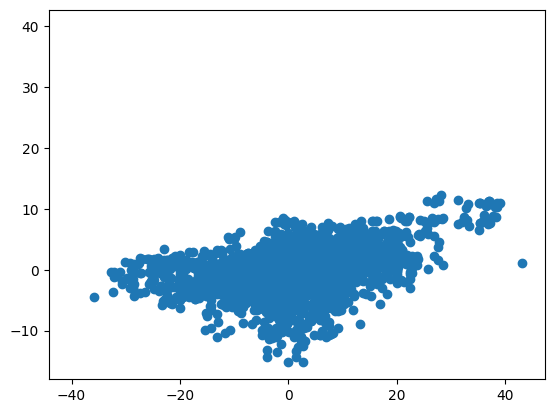

In [26]:
plt.scatter(
    y_test,
    model.predict(X_test)
)
plt.plot([-40,-40], [40,40])

In [27]:
spearmanr(
    y_test,
    model.predict(X_test)
)

SpearmanrResult(correlation=0.2908483610465659, pvalue=2.0997814308456016e-84)

<BarContainer object of 33 artists>

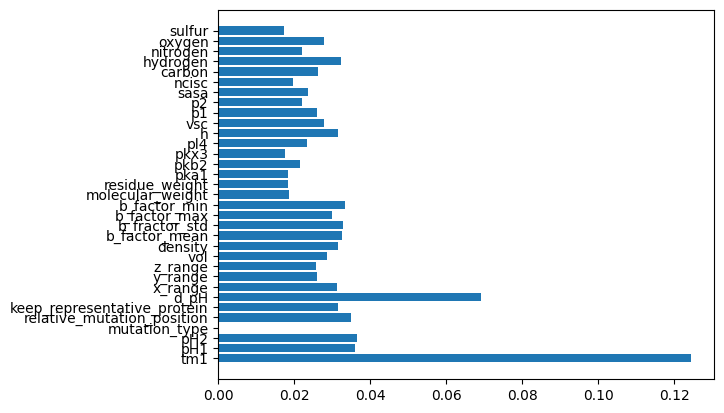

In [28]:
plt.barh(X_test.columns, model.feature_importances_, )